# Import libraries

In [2]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Create corpus

In [3]:
root_dir = "/kaggle/input/poemsdataset/topics"
corpus = []
corpus_size = 10000
done = False

print("Loading poems in corpus...\n")
for dirname, _, filenames in os.walk(root_dir):
    if done: break
    print(f"Loading {dirname}")
    for filename in filenames:
        if done: break
        with open(os.path.join(dirname, filename), "r") as file:
            txt = file.read()
            for line in txt.split("\n"):
                if done: break
                corpus.append(line)
                if len(corpus) == corpus_size:
                    done = True

Loading poems in corpus...

Loading /kaggle/input/poemsdataset/topics
Loading /kaggle/input/poemsdataset/topics/moon
Loading /kaggle/input/poemsdataset/topics/beauty
Loading /kaggle/input/poemsdataset/topics/joy
Loading /kaggle/input/poemsdataset/topics/hero


In [4]:
len(corpus)

10000

In [5]:
corpus[:10]

["Press'd by the Moon, mute arbitress of tides,",
 'While the loud equinox its power combines,',
 'The sea no more its swelling surge confines,',
 "But o'er the shrinking land sublimely rides.",
 'The wild blast, rising from the Western cave,',
 'Drives the huge billows from their heaving bed;',
 'Tears from their grassy tombs the village dead,',
 'And breaks the silent sabbath of the grave!',
 'With shells and sea-weed mingled, on the shore',
 'Lo! their bones whiten in the frequent wave;']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [6]:
import string

def remove_punc(s):
    s = s.replace(',', ' <COMMA> ').replace('\n', ' <END> ')
    translator = str.maketrans('', '', string.punctuation.replace('<', '').replace('>', ''))
    return s.translate(translator)

corpus = [remove_punc(s.lower().strip()) for s in corpus]

In [7]:
corpus[:10]

['pressd by the moon <COMMA>  mute arbitress of tides <COMMA> ',
 'while the loud equinox its power combines <COMMA> ',
 'the sea no more its swelling surge confines <COMMA> ',
 'but oer the shrinking land sublimely rides',
 'the wild blast <COMMA>  rising from the western cave <COMMA> ',
 'drives the huge billows from their heaving bed',
 'tears from their grassy tombs the village dead <COMMA> ',
 'and breaks the silent sabbath of the grave',
 'with shells and seaweed mingled <COMMA>  on the shore',
 'lo their bones whiten in the frequent wave']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [9]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9332


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [10]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 64006
Maximum n-gram length: 269


In [11]:
for n_gram in n_grams[:10]:
    print(n_gram)

[4222, 43]
[4222, 43, 2]
[4222, 43, 2, 34]
[4222, 43, 2, 34, 1]
[4222, 43, 2, 34, 1, 1015]
[4222, 43, 2, 34, 1, 1015, 4223]
[4222, 43, 2, 34, 1, 1015, 4223, 4]
[4222, 43, 2, 34, 1, 1015, 4223, 4, 1327]
[4222, 43, 2, 34, 1, 1015, 4223, 4, 1327, 1]
[151, 2]


## Pad n-grams

In [12]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(64006, 100)

In [13]:
for seq in padded_n_grams[:3]:
    print(seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 4222   43]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

## Split n-grams into X and y

In [14]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (64006, 99)
y: (64006,)


In [15]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (64006, 9332)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [17]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", f1_m, precision_m, recall_m]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 300)           2799600   
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 9332)              1409132   
                                                                 
Total params: 4,479,332
Trainable params: 4,479,332
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(
    X, 
    y, 
    epochs=125,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/125
501/501 [==============================] - 44s 78ms/step - loss: 6.9353 - accuracy: 0.0905 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/125
501/501 [==============================] - 13s 26ms/step - loss: 6.4060 - accuracy: 0.1163 - f1_m: 0.0031 - precision_m: 0.1426 - recall_m: 0.0016
Epoch 3/125
501/501 [==============================] - 10s 21ms/step - loss: 6.1495 - accuracy: 0.1260 - f1_m: 0.0235 - precision_m: 0.5646 - recall_m: 0.0121
Epoch 4/125
501/501 [==============================] - 10s 19ms/step - loss: 5.9404 - accuracy: 0.1363 - f1_m: 0.0509 - precision_m: 0.7058 - recall_m: 0.0266
Epoch 5/125
501/501 [==============================] - 12s 23ms/step - loss: 5.7500 - accuracy: 0.1503 - f1_m: 0.0692 - precision_m: 0.7600 - recall_m: 0.0366
Epoch 6/125
501/501 [==============================] - 10s 20ms/step - loss: 5.5759 - accuracy: 0.1596 - f1_m: 0.0886 - precision_m: 0.7673 - recall_m: 0.0474
Epoch 7/125
501/501 [=============

# Plot learning curves

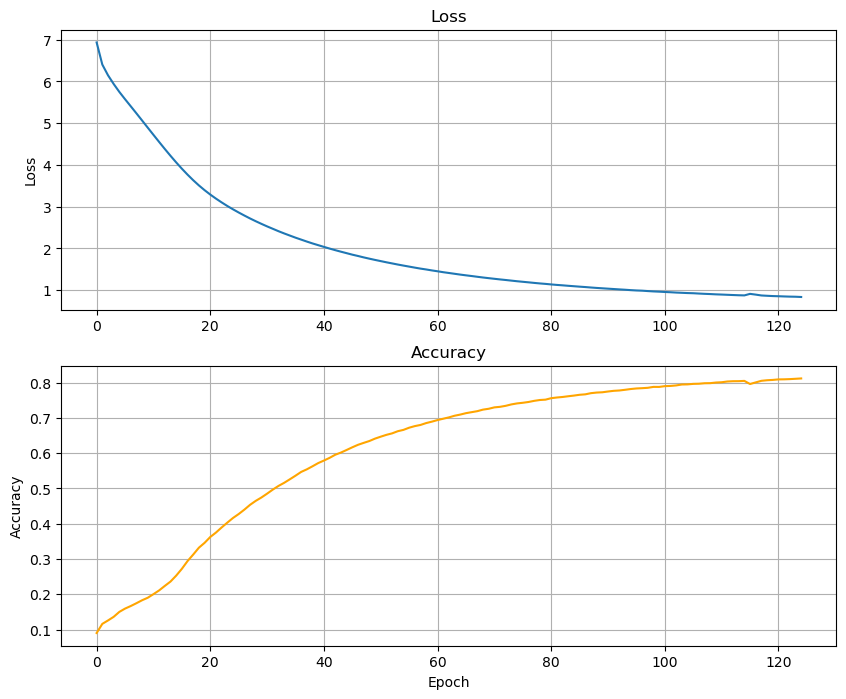

In [19]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

In [20]:
# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X, y, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F1 Score: {f1_score}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

Test Loss: 0.7774218320846558
Test Accuracy: 0.826500654220581
Test F1 Score: 0.8531566858291626
Test Precision: 0.9800814986228943
Test Recall: 0.7608487606048584


# Poetry generation

In [21]:
def generate(seed_text, next_words):
    generated_text = seed_text
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        
        if output_word == 'end':
            generated_text += '.\n'
        elif output_word == 'comma':
            generated_text += ',\n'
        else:
            generated_text += output_word + " "

        seed_text += " " + output_word
    
    print(generated_text)


In [22]:
generate("Long live the king", 200)

Long live the kingand the web he explores for me in act ,
the world ,
when she laid me in the sky of the weary far over the lord who of nature and the famine in guannei ,
i repeated her words or she head ,
twere me when i noticed i repeated her words a little at a time there was a lot more then what i wrote in this story i dont know how to thank her ,
maybe this story will do more than i think thank you for being my hero and in your hearts close their eyes for me and i am and im where they close and thought in peace was i am the ever virgin your forefathers worshipped ,
and to my honor they erected shrines and temples at baalbek and jbeil and i dared say ,
but those temples and shrines were laid waste and the bones of my adoring ancestors became a part of the earth nothing was left to commemorate their goddess save a pitiful few and the forgotten pages in the book of history and think what it got ever join in largeness and in the things ive im the mirror 
